# User Engagement Analysis

In [3]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

# Print connection details (without password)
print(f"Attempting to connect to:")
print(f"Database: {os.getenv('DB_NAME')}")
print(f"User: {os.getenv('DB_USER')}")
print(f"Host: {os.getenv('DB_HOST')}")
print(f"Port: {os.getenv('DB_PORT')}")

try:
    conn = psycopg2.connect(
        dbname=os.getenv('DB_NAME'),
        user=os.getenv('DB_USER'),
        password=os.getenv('DB_PASSWORD'),
        host=os.getenv('DB_HOST'),
        port=os.getenv('DB_PORT')
    )
    print("Successfully connected to database!")
    conn.close()
except Exception as e:
    print(f"Connection failed: {e}")

Attempting to connect to:
Database: telecom_db
User: postgres
Host: localhost
Port: 5432
Successfully connected to database!


### Load the XDR data with error checking

In [4]:
import pandas as pd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append('../scripts')  # Add scripts folder to Python path
from visualization_utils import plot_histogram, plot_boxplot, plot_heatmap, scatter_pca, plot_pie_chart, plot_bar_chart
from load_data import load_table_to_dataframe # to load the data
# Load the XDR data with error checking
xdr_data = load_table_to_dataframe("xdr_data")
if xdr_data is None:
    print("Failed to load data. Please check:")
    print("1. Database connection settings in .env file")
    print("2. Database is running and accessible")
    print("3. Table 'xdr_data' exists in the database")
else:
    print(xdr_data.head())


      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

### Aggregate Metrics Per Customer (MSISDN)


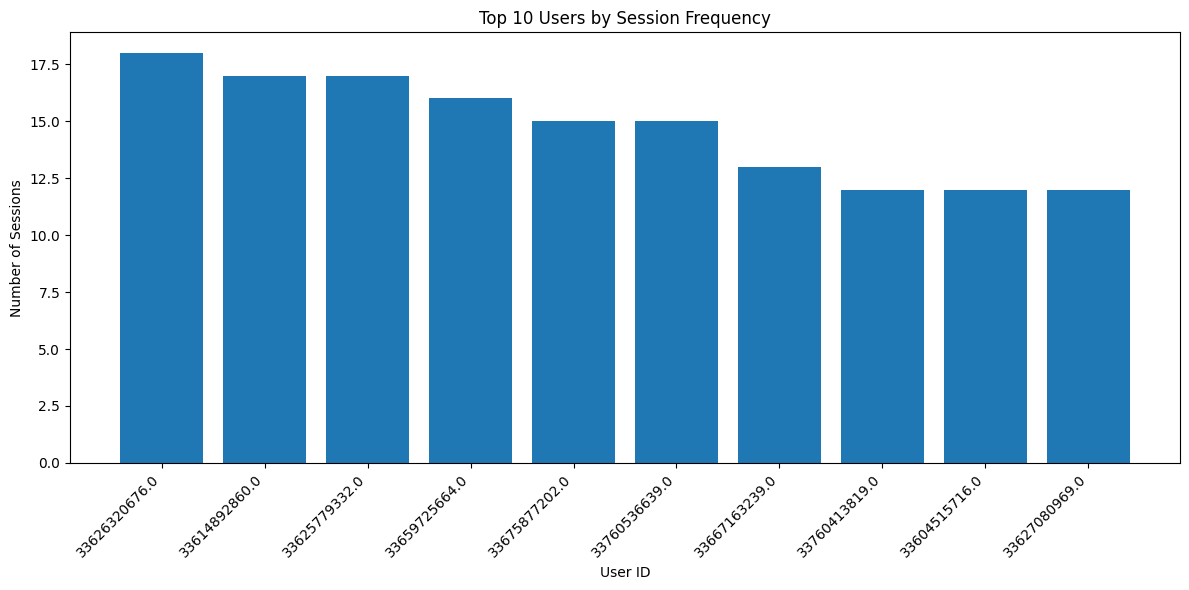

In [5]:
# Aggregating metrics per customer (MSISDN)
user_engagement = xdr_data.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',   # Total session duration
    'Total UL (Bytes)': 'sum',  # Total upload data
    'Total DL (Bytes)': 'sum',  # Total download data
    'Bearer Id': 'count'  # Session frequency
}).reset_index()

# Rename columns for clarity
user_engagement.rename(columns={
    'Dur. (ms)': 'Total Session Duration (ms)',
    'Total UL (Bytes)': 'Total Upload (Bytes)',
    'Total DL (Bytes)': 'Total Download (Bytes)',
    'Bearer Id': 'Session Frequency'
}, inplace=True)

# Add Total Data Volume column
user_engagement['Total Data Volume (Bytes)'] = (
    user_engagement['Total Upload (Bytes)'] + user_engagement['Total Download (Bytes)']
)


# Create bar chart for top 10 users by session frequency
top_10_frequency = user_engagement.sort_values('Session Frequency', ascending=False).head(10)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_10_frequency)), top_10_frequency['Session Frequency'])
plt.xticks(range(len(top_10_frequency)), 
           top_10_frequency['MSISDN/Number'],
           rotation=45,
           ha='right')
plt.title('Top 10 Users by Session Frequency')
plt.xlabel('User ID')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()


### Normalize Engagement Metrics


   MSISDN/Number  Total Session Duration (ms)  Total Upload (Bytes)  \
0   3.360100e+10                     0.005908            36053108.0   
1   3.360100e+10                     0.009387            36104459.0   
2   3.360100e+10                     0.006892            39306820.0   
3   3.360101e+10                     0.002304            20327526.0   
4   3.360101e+10                     0.001615            94280527.0   

   Total Download (Bytes)  Session Frequency  Total Data Volume (Bytes)  
0            8.426375e+08           0.055556                   0.095931  
1            1.207552e+08           0.055556                   0.014026  
2            5.566597e+08           0.055556                   0.063851  
3            4.019932e+08           0.055556                   0.044148  
4            1.363130e+09           0.111111                   0.161598  


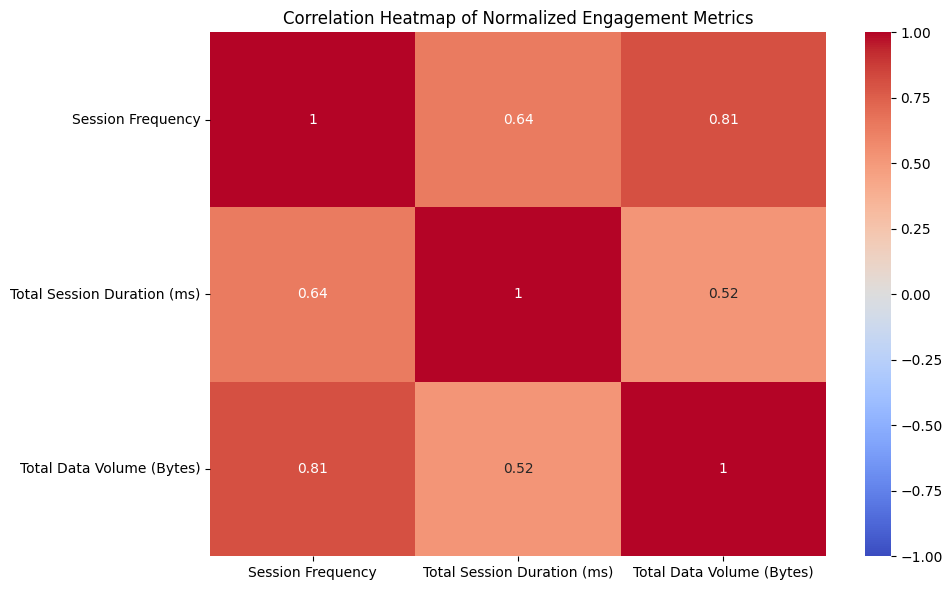

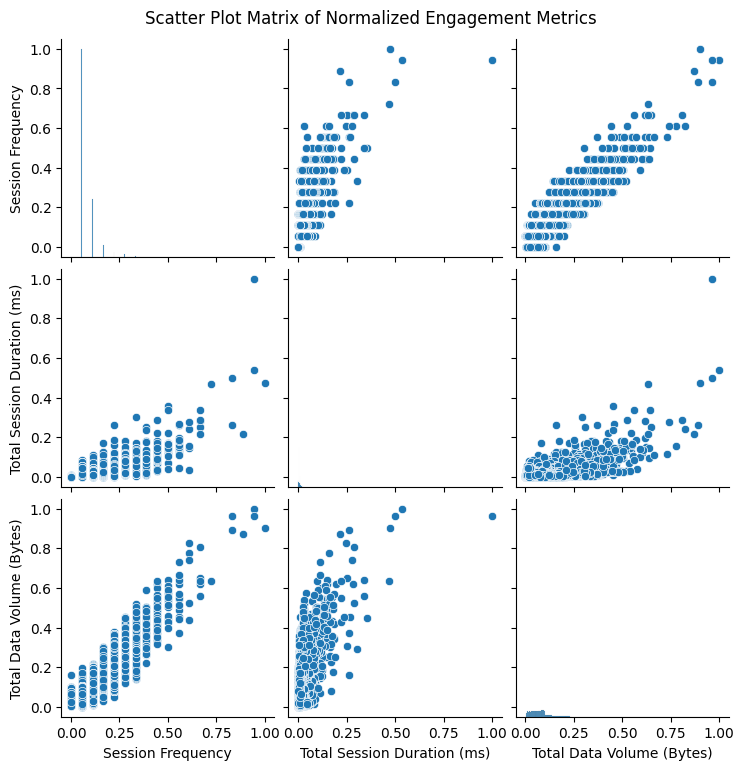

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Select metrics for normalization
metrics = ['Session Frequency', 'Total Session Duration (ms)', 'Total Data Volume (Bytes)']
scaler = MinMaxScaler()

# Normalize the metrics
user_engagement_normalized = user_engagement.copy()
user_engagement_normalized[metrics] = scaler.fit_transform(user_engagement[metrics])

# Display the normalized dataframe
print(user_engagement_normalized.head())

# Visualization 

# Create a heatmap of normalized metrics
plt.figure(figsize=(10, 6))
sns.heatmap(user_engagement_normalized[metrics].corr(), 
            annot=True, 
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)
plt.title('Correlation Heatmap of Normalized Engagement Metrics')
plt.tight_layout()
plt.show()

# Create a scatter plot matrix
sns.pairplot(user_engagement_normalized[metrics])
plt.suptitle('Scatter Plot Matrix of Normalized Engagement Metrics', y=1.02)
plt.show()


### Apply K-means Clustering (k=3)

                   Session Frequency                \
                                 min max      mean   
Engagement Cluster                                   
0                                  1   4  2.184791   
1                                  3  18  4.258194   
2                                  0   2  1.043550   

                   Total Session Duration (ms)                             \
                                           min         max           mean   
Engagement Cluster                                                          
0                                      18235.0   3174824.0  215100.806229   
1                                      49323.0  18553754.0  572159.112084   
2                                       7142.0   1573420.0  107473.680857   

                   Total Data Volume (Bytes)                              
                                         min           max          mean  
Engagement Cluster                                            

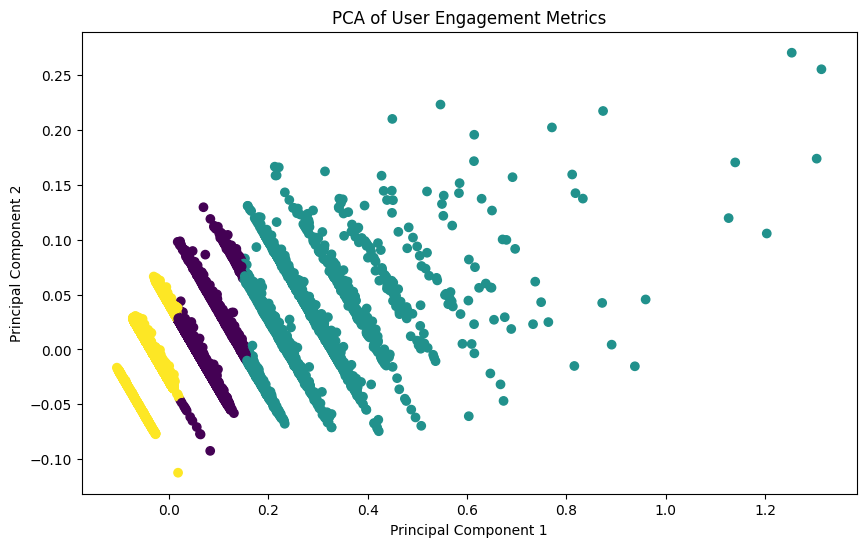

In [7]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement_normalized['Engagement Cluster'] = kmeans.fit_predict(user_engagement_normalized[metrics])

# Add cluster labels to the original dataframe
user_engagement['Engagement Cluster'] = user_engagement_normalized['Engagement Cluster']

# Display cluster summary
print(user_engagement.groupby('Engagement Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean'],
    'Total Session Duration (ms)': ['min', 'max', 'mean'],
    'Total Data Volume (Bytes)': ['min', 'max', 'mean']
}))

# Visualization

# Create a scatter plot of the first two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_engagement_normalized[metrics])
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=user_engagement_normalized['Engagement Cluster'], cmap='viridis')
plt.title('PCA of User Engagement Metrics')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Top 10 Most Engaged Users per Application



Top 10 Users by Social Traffic:
        MSISDN/Number  Total Social Traffic
13526    3.362632e+10            42743837.0
92923    3.376054e+10            39297646.0
37052    3.365973e+10            34900444.0
6437     3.361489e+10            27749744.0
13180    3.362578e+10            26564121.0
65118    3.366716e+10            23753753.0
106137   3.378632e+10            23568655.0
70960    3.366907e+10            23477047.0
666      3.360313e+10            22776679.0
31331    3.365849e+10            22695673.0
Top 10 Users by Social Traffic:
        MSISDN/Number  Total Social Traffic
13526    3.362632e+10              630942.0
13180    3.362578e+10              571379.0
76363    3.367588e+10              567557.0
6437     3.361489e+10              544800.0
37052    3.365973e+10              511914.0
65118    3.366716e+10              494097.0
92923    3.376054e+10              485543.0
30715    3.365836e+10              420146.0
35436    3.365936e+10              409564.0
106137   3.3

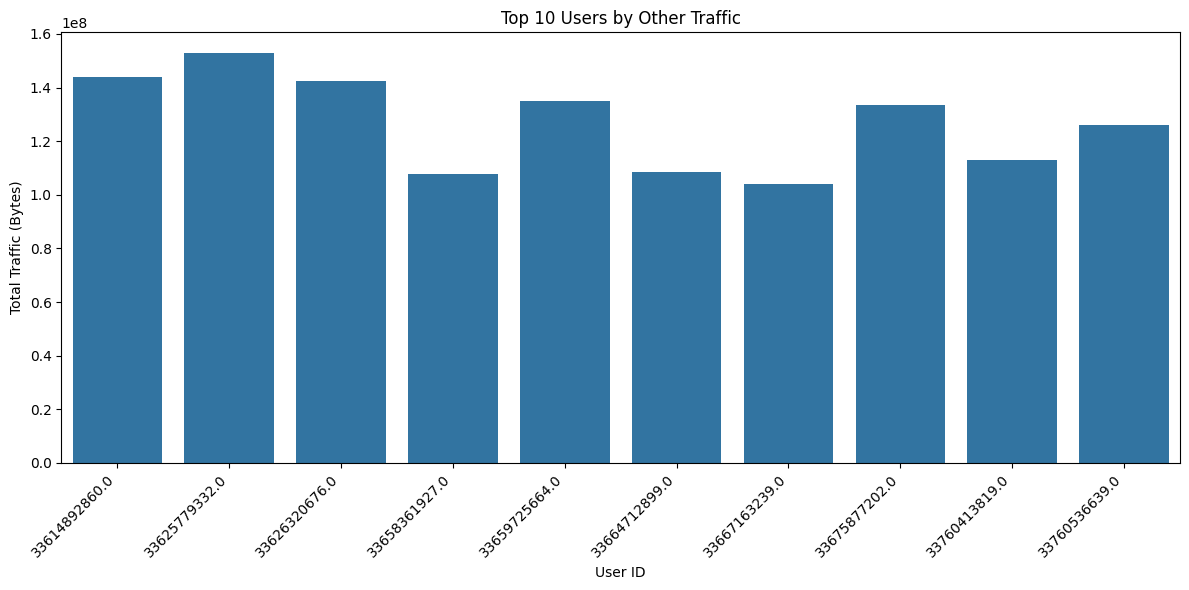

In [8]:
# List of application columns
applications = [
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)'
]

# Aggregate total traffic per application
for app in applications:
    app_agg = xdr_data.groupby('MSISDN/Number')[app].sum().reset_index()
    app_agg.columns = ['MSISDN/Number', f'Total {app.split()[0]} Traffic']
    top_10_app = app_agg.sort_values(f'Total {app.split()[0]} Traffic', ascending=False).head(10)
    print(f"Top 10 Users by {app.split()[0]} Traffic:")
    print(top_10_app)

# Visualization

# Create a bar chart for the top 10 users by application traffic
plt.figure(figsize=(12, 6))
sns.barplot(x='MSISDN/Number', y=f'Total {app.split()[0]} Traffic', data=top_10_app)
plt.title(f'Top 10 Users by {app.split()[0]} Traffic')
plt.xlabel('User ID')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Plot Top 3 Most Used Applications



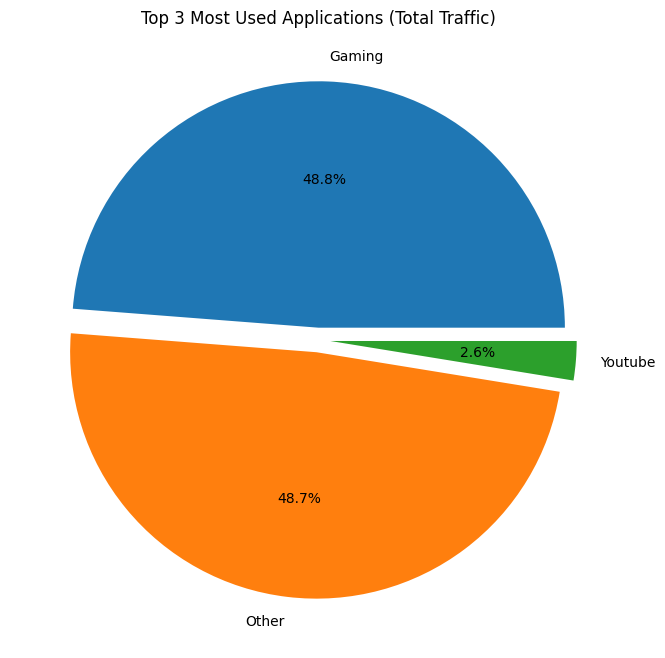


Top 3 Applications by Total Traffic:
Gaming: 64,550,395,439,016.7 bytes
Other: 64,405,230,908,181.62 bytes
Youtube: 3,396,545,039,272.6387 bytes


In [9]:
# Calculate total traffic for each application type
app_totals = pd.Series({
    'Social Media': xdr_data['Social Media DL (Bytes)'].sum() + xdr_data['Social Media UL (Bytes)'].sum(),
    'Google': xdr_data['Google DL (Bytes)'].sum() + xdr_data['Google UL (Bytes)'].sum(),
    'Email': xdr_data['Email DL (Bytes)'].sum() + xdr_data['Email UL (Bytes)'].sum(),
    'Youtube': xdr_data['Youtube DL (Bytes)'].sum() + xdr_data['Youtube UL (Bytes)'].sum(),
    'Netflix': xdr_data['Netflix DL (Bytes)'].sum() + xdr_data['Netflix UL (Bytes)'].sum(),
    'Gaming': xdr_data['Gaming DL (Bytes)'].sum() + xdr_data['Gaming UL (Bytes)'].sum(),
    'Other': xdr_data['Other DL (Bytes)'].sum() + xdr_data['Other UL (Bytes)'].sum()
})

# Get top 3 applications
top_3_apps = app_totals.nlargest(3)

# Create a pie chart for the top 3 apps
plt.figure(figsize=(10, 8))
plt.pie(top_3_apps, 
        labels=top_3_apps.index,
        autopct='%1.1f%%',
        explode=[0.05] * 3)  # slight separation for visibility
plt.title('Top 3 Most Used Applications (Total Traffic)')
plt.show()

# Print the actual values
print("\nTop 3 Applications by Total Traffic:")
for app, traffic in top_3_apps.items():
    print(f"{app}: {traffic:,} bytes")

### Optimize k for K-means Clustering

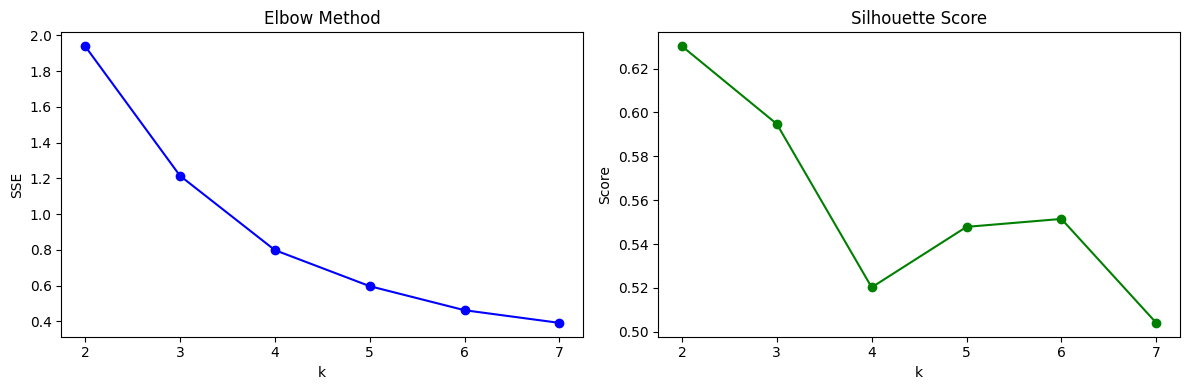


Optimal k = 2


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def find_optimal_clusters_fast(data, max_k=10, min_k=2, sample_size=1000):
    """
    Find optimal number of clusters using both elbow method and silhouette score.
    Uses sampling for speed and efficiency.
    """
    # Convert to numpy array if it's a DataFrame
    X = data.values if hasattr(data, 'values') else data
    
    # Sample the data if it's larger than sample_size
    if X.shape[0] > sample_size:
        np.random.seed(42)
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X = X[indices]
    
    # Initialize arrays
    k_values = range(min_k, max_k)
    sse = []
    silhouette_scores = []
    
    # Compute metrics for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, 
                       random_state=42, 
                       n_init=5,  # Reduced number of initializations
                       max_iter=100)  # Reduced max iterations
        labels = kmeans.fit_predict(X)
        sse.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        
        # Progress indicator
        print(f"Processed k={k}", end='\r')
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(k_values, sse, 'bo-')
    ax1.set_title('Elbow Method')
    ax1.set_xlabel('k')
    ax1.set_ylabel('SSE')
    
    ax2.plot(k_values, silhouette_scores, 'go-')
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k
    optimal_k = min_k + np.argmax(silhouette_scores)
    print(f"\nOptimal k = {optimal_k}")
    return optimal_k

# Use the function with sampling
if 'metrics' in locals() and 'user_engagement_normalized' in locals():
    optimal_k = find_optimal_clusters_fast(
        user_engagement_normalized[metrics],
        max_k=8,  # Reduced maximum k
        min_k=2,
        sample_size=1000  # Sample size for faster processing
    )
else:
    print("Please ensure 'metrics' and 'user_engagement_normalized' are defined")